In [45]:
import load_ship_data
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import mpp_classifiers as mpp
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import load_flat_ncolor_data as loader

In [2]:
# set seed
np.random.seed(522)
# load data
path = './data/shipsnet.json'
train, test, val = load_ship_data.load_data_train_test_split(path)

Training Set Data Length:  2800   Label Length:  2800
TestingSet Set Data Length:  600  Label Length:  600
Validation Set Data Length:  600  Label Length:  600


In [47]:
# alternate
np.random.seed(522)
train, test, labels_tr, labels_te = loader.load_data_and_convert(path, 2)

Training Set Data Length:  2800   Label Length:  2800
TestingSet Set Data Length:  600  Label Length:  600
Validation Set Data Length:  600  Label Length:  600
[102  99  99 103 104 100 104 105 103 108]


In [48]:
train_flat = train.reshape(train.shape[0], 19200)
test_flat = test.reshape(test.shape[0], 19200)

In [51]:
samples = train_flat
labels = labels_tr

In [3]:
train, labels_tr = train
test, labels_te = test
val, labels_val = val

# completely flatten
train_flat = train.reshape(train.shape[0], 19200)
test_flat = test.reshape(test.shape[0], 19200)
val_flat = val.reshape(val.shape[0], 19200)

# flatten pixels only (for color reduction)
train_rgb = train.reshape(train.shape[0], 3, 6400)
test_rgb = test.reshape(test.shape[0], 3, 6400)
val_rgb = val.reshape(val.shape[0], 3, 6400)
# move channels to last axis
train_rgb = np.swapaxes(train_rgb, 1, 2)
test_rgb = np.swapaxes(test_rgb, 1, 2)
val_rgb = np.swapaxes(test_rgb, 1, 2)

In [52]:
# combine train and val for use in sklearn's KFold function
#samples = np.concatenate((train_flat, val_flat), axis=0)
#labels = np.concatenate((labels_tr, labels_val), axis=None)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(samples, labels)

5

# K-means

K-means predictions are absolutely horrendous. This is not particulary surprising, as k-means is attempting to cluster like pixels together across all of the images and 3 color channels. That's a fine idea, but is not capable of taking rotation of images into account.

However, k-means can also be used as a form of dimensionality reduction by segmenting images into clusters before applying a different algorithm. This application can do something like clearly split ocean from a ship.

In [5]:
accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    kmeans = KMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = samples[train_idx], samples[test_idx]
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

print(f'{round(np.mean(np.array(times)), 2)} seconds')
print(accuracies)

62.6 seconds
[[0.52058824 0.77878788 0.27714286]
 [0.53088235 0.79204893 0.28895184]
 [0.53529412 0.29608939 0.80124224]
 [0.54117647 0.29829545 0.80182927]
 [0.55       0.79479769 0.29640719]]


In [19]:
pca = PCA(n_components = 2, svd_solver = 'full')
pca.fit(samples)

accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    if i == 3: break
    start_time = time.time()
    kmeans = KMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = pca.transform(samples[train_idx]), pca.transform(samples[test_idx])
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

end_time = time.time() - start_time
print(f'{round(end_time, 2)} seconds')
print(accuracies)

1.03 seconds
[[0.51911765 0.7781155  0.27635328]
 [0.52794118 0.28611898 0.78899083]
 [0.53529412 0.29608939 0.80124224]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In [57]:
pca = PCA(n_components = 0.90, svd_solver = 'full')
pca.fit(samples)
accuracies = np.zeros((5, 3))
times = []

for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    #if i != 1: continue
    start_time = time.time()
    kmeans = RandomForestClassifier(warm_start=True, n_estimators=140, random_state=522)
    train_n, test_n = pca.transform(samples[train_idx]), pca.transform(samples[test_idx])
    train_n, test_n = samples[train_idx], samples[test_idx]
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n, labels_tr_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    #if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)
    #break

print(f'{round(np.mean(np.array(times)), 2)} seconds')
print(accuracies)

27.03 seconds
[[0.95       0.95419847 0.93589744]
 [0.96176471 0.96538462 0.95      ]
 [0.95441176 0.96324952 0.92638037]
 [0.94705882 0.94052045 0.97183099]
 [0.95441176 0.9596929  0.93710692]]


In [ ]:
#results = kmeans.predict(pca.transform(test_flat))
results = kmeans.predict(test_flat)
np.save('./data/kmeans_pca_2.npy', results)

# WTA

In [7]:
accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    kmeans = MiniBatchKMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = samples[train_idx], samples[test_idx]
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

print(f'{round(np.mean(np.array(times)), 2)} seconds')
print(accuracies)

8.38 seconds
[[0.50294118 0.22368421 0.7287234 ]
 [0.5        0.71573604 0.2027972 ]
 [0.52352941 0.2962963  0.80794702]
 [0.54117647 0.29829545 0.80182927]
 [0.56470588 0.303125   0.79722222]]


In [8]:
pca = PCA(n_components = 2, svd_solver = 'full')
pca.fit(samples)

accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    MiniBatchkmeans = KMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = pca.transform(samples[train_idx]), pca.transform(samples[test_idx])
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

end_time = time.time() - start_time
print(f'{round(end_time, 2)} seconds')
print(accuracies)

0.48 seconds
[[0.50147059 0.22295082 0.728     ]
 [0.51029412 0.28608924 0.79598662]
 [0.51911765 0.29396325 0.80602007]
 [0.53823529 0.29661017 0.8006135 ]
 [0.56176471 0.79608939 0.30124224]]


## n-color K-means

In [ ]:
def images_to_n_colors(images, n_colors, n_subpixels=1000, sample_number=None):
    kmeans = KMeans(n_clusters=n_colors, random_state=522)
    all_centers, all_labels = [], []
    num_imgs = images.shape[0]
    for i in range(num_imgs):
        if sample_number is not None:
            if i < sample_number: continue
        img = images[i, :] / 255
        img_sample = shuffle(img, random_state=522)[:n_subpixels]
        kmeans.fit(img_sample)
        labels = kmeans.predict(img)
        if sample_number is not None:
            return(kmeans, labels)
        else:
            all_centers.append(kmeans.cluster_centers_)
            all_labels.append(labels)
    return(all_centers, all_labels)
        
def recreate_image(clusters, labels, n_colors, flat=False):
    img = np.zeros((80, 80, 3))
    label_idx = 0
    for i in range(80):
        for j in range(80):
            img[i][j] = clusters[labels[label_idx]]
            #img[i][j] = labels[label_idx] / n_colors
            label_idx += 1
    if flat == True:
        return img.reshape(19200)
    else:
        return img

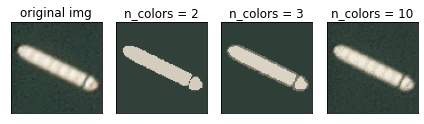

1


In [54]:
#fig, axes = plt.subplots(2, 2)
#axes = [ax for sublist in axes for ax in sublist]
fig, axes = plt.subplots(1, 4)
#fig, axes = plt.subplots()
#axes = [axes]
n_colors = [2, 3, 10]
#n_colors = [2]
sample_number = 6
n_subpixels = 1000
for i, ax in enumerate(axes):
    if i == 0:
        #ax.imshow(train_rgb[sample_number].reshape(80, 80, 3) / 255)
        ax.imshow(test_rgb[sample_number].reshape(80, 80, 3) / 255)
        ax.set_title('original img')
    else:
        kmeans, labels = images_to_n_colors(test_rgb, n_colors[i-1], n_subpixels, sample_number)
        ax.imshow(recreate_image(kmeans.cluster_centers_, labels, n_colors[i-1]))
        ax.set_title(f'n_colors = {str(n_colors[i-1])}')
    ax.set_xticks([])
    ax.set_yticks([])
        
plt.tight_layout()
plt.show()
#print(labels_tr[sample_number])
print(labels_te[sample_number])

In [6]:
all_centers, all_labels = images_to_n_colors(train_rgb, 2)

train_flat2 = np.zeros((2800, 19200))
for i in range(2800):
    train_flat2[i, :] = recreate_image(all_centers[i], all_labels[i], n_colors=2, flat=True)

In [7]:
all_centers, all_labels = images_to_n_colors(test_rgb, 2)

test_flat2 = np.zeros((600, 19200))
for i in range(600):
    test_flat2[i, :] = recreate_image(all_centers[i], all_labels[i], n_colors=2, flat=True)

In [8]:
tree = DecisionTreeClassifier()
tree.fit(train_flat2, labels_tr)
np.mean(tree.predict(test_flat2) == labels_te)

0.9033333333333333

In [320]:
pca = PCA(n_components=50)
pca.fit(train_flat2)
pca_train = pca.transform(train_flat2)
pca_test = pca.transform(test_flat2)

p = [0.74464286, 0.25535714]
y_model = mpp.mpp(pca_train, labels_tr, pca_test, 2, p)

acc_classwise, acc_overall = mpp.accuracy_score(labels_te, y_model)
print(acc_classwise)
print(acc_overall)

[0.96043956 0.80689655]
0.9233333333333333


In [22]:
#n_colors = 2
#all_centers, all_labels = images_to_n_colors(train_rgb, n_colors)
#train_flat_n = np.zeros((2800, 19200))
for i in range(2800):
    break
    train_flat_n[i, :] = recreate_image(all_centers[i], all_labels[i], n_colors=n_colors, flat=True)
    
tree = DecisionTreeClassifier()
tree.fit(train_flat2, labels_tr)
np.mean(tree.predict(test_flat2) == labels_te)

NameError: name 'train_flat2' is not defined

In [21]:
predict = tree.predict(test_flat2)
idx0 = np.where(predict != labels_te)
idx0

NameError: name 'tree' is not defined

accuracies of test set with n colors:

2: 0.76

3: 0.76

10: 0.76

100: 0.76